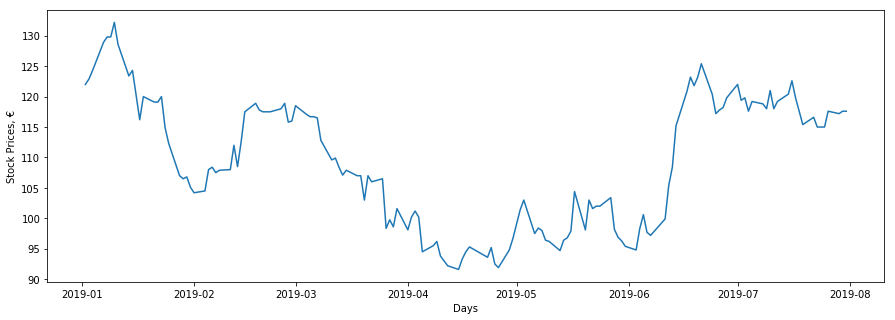

        Date  Close
0 2019-07-01  122.0
1 2019-07-02  119.4
2 2019-07-03  119.8
3 2019-07-04  117.6
4 2019-07-05  119.2
         Date  Close
18 2019-07-25  115.0
19 2019-07-26  117.6
20 2019-07-29  117.2
21 2019-07-30  117.6
22 2019-07-31  117.6
[-0.02131147540983602, 0.003350083752093731, -0.01836393989983308, 0.01360544217687082, -0.003355704697986625, -0.00673400673400671, 0.025423728813559324, -0.024793388429752067, 0.010169491525423752, 0.010067114093959755, 0.01827242524916934, -0.022838499184339292, -0.01836393989983308, -0.01870748299319718, 0.010398613518197474, -0.01372212692967405, 0.0, 0.0, 0.022608695652173865, -0.0034013605442176145, 0.0034129692832763777, 0.0]
[-0.00166811 -0.00333623 -0.00500434 -0.00667245 -0.00834057 -0.01000868
 -0.01167679 -0.0133449  -0.01501302 -0.01668113 -0.01834924 -0.02001736
 -0.02168547 -0.02335358 -0.0250217  -0.02668981 -0.02835792 -0.03002603
 -0.03169415 -0.03336226 -0.03503037 -0.03669849]
{'1': array([ 0.01083076,  0.00288291, -0.00580

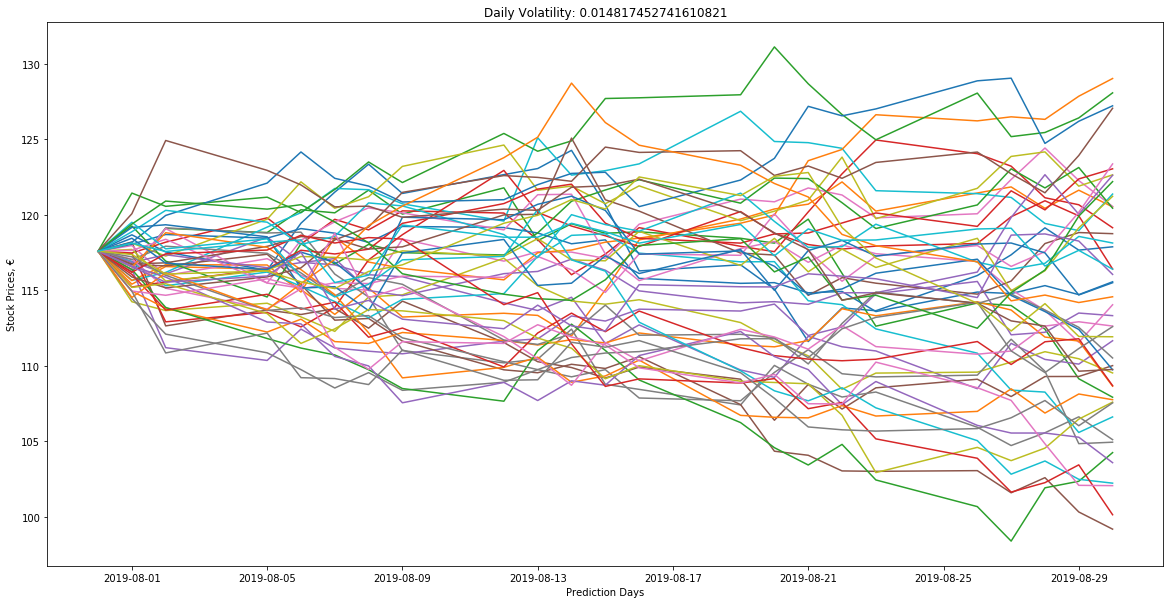

In [30]:
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

stock_name = 'FSE/ZO1_X'

# Plot of E.ON(a big scale energy company in Europe) 
#stock prices since beginning of 2019 (up to July)
prices = quandl.get(stock_name, 
                authtoken="ji7D3fqwa5shD8E_zBsw", 
                start_date = '2019-01-01', end_date = '2019-07-31'
                ).reset_index(drop = False)[['Date', 'Close']]
plt.figure(figsize = (15, 5))
plt.plot(prices['Date'], prices['Close'])
plt.xlabel('Days')
plt.ylabel('Stock Prices, €')
plt.show()

#--------------------------------------------------- GEOMETRIC BROWNIAN MOTION ------------------------------------------------

# Parameter Definitions

# So    :   initial stock price
# dt    :   time increment -> a day in our case
# T     :   length of the prediction time horizon(how many time points to predict, same unit with dt(days))
# N     :   number of time points in prediction the time horizon -> T/dt
# t     :   array for time points in the prediction time horizon [1, 2, 3, .. , N]
# mu    :   mean of historical daily returns
# sigma :   standard deviation of historical daily returns
# b     :   array for brownian increments
# W     :   array for brownian path

start_date = '2019-07-01'
end_date = '2019-07-31'
pred_end_date = '2019-08-31'

# We get daily closing stock prices of E.ON for July 2019
S_eon = quandl.get(stock_name, 
               authtoken="ji7D3fqwa5shD8E_zBsw", 
               start_date = start_date, end_date = end_date
               ).reset_index(drop = False)[['Date', 'Close']]
print(S_eon.head())
print(S_eon.tail())

returns = (S_eon.loc[1:, 'Close'] - \
           S_eon.shift(1).loc[1:, 'Close']) / \
           S_eon.shift(1).loc[1:, 'Close']
print(returns.tolist())


# Parameter Assignments
So = S_eon.loc[S_eon.shape[0] - 1, "Close"]
dt = 1 # day   # User input
n_of_wkdays = pd.date_range(start = pd.to_datetime(end_date, 
                 format = "%Y-%m-%d") + pd.Timedelta('1 days'), 
                 end = pd.to_datetime(pred_end_date, 
                 format = "%Y-%m-%d")).to_series().map(lambda x: 
                 1 if x.isoweekday() in range(1,6) else 0).sum()
T = n_of_wkdays # days  # User input -> follows from pred_end_date
N = T / dt
t = np.arange(1, int(N) + 1)
mu = np.mean(returns)
sigma = np.std(returns)
scen_size = 50 # User input
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}


# Calculating drift and diffusion components
drift = (mu - 0.5 * sigma**2) * t
print(drift)
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
print(diffusion)


# Making the predictions
S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
S = np.hstack((np.array([[So] for scen in range(scen_size)]), S)) # add So to the beginning series
print(S)


# Plotting the simulations
plt.figure(figsize = (20,10))
for i in range(scen_size):
    plt.title("Daily Volatility: " + str(sigma))
    plt.plot(pd.date_range(start = S_eon["Date"].max(), 
                end = pred_end_date, freq = 'D').map(lambda x:
                x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S[i, :])
    plt.ylabel('Stock Prices, €')
    plt.xlabel('Prediction Days')
plt.show()

# Dataframe format for predictions - first 10 scenarios only
Preds_df = pd.DataFrame(S.swapaxes(0, 1)[:, :10]).set_index(
           pd.date_range(start = S_eon["Date"].max(), 
           end = pred_end_date, freq = 'D').map(lambda x:
           x if x.isoweekday() in range(1, 6) else np.nan).dropna()
           ).reset_index(drop = False)